# Script for crafting Adversarial Examples

In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import utils.text_processing as tp

In [2]:
# get data from important word detector
%store -r important_words
%store -r sentence_packages

## Methed 2: Mispeeling

#### 1. Create modified Dataset

In [3]:
original_sentences = []
for sentence in sentence_packages:
    original_sentences.append(sentence['original_sentence'])

##### über die gehen
##### word = bleibt gleich
##### typos = Liste alle wörter von index +1 bis zum nächsten Wort, das mit 'Dollar' anfaengt Dieses nicht.

##### dann im nächsten Schritt - für die Länge der Liste Typos über den Satz itereiren und das important word mit dem typo an der index stelle austauschen.





In [4]:
with open(os.path.join('data','birkbeck_corpera_typo.txt'), 'r') as f:
    typods = f.readlines()
    
typodict = {}
for index, item in enumerate(typods):    
    
    if typods[index][0] == '$':
        word = typods[index].rstrip().strip('$')
        i = 1
        typos = []
        while index+i < len(typods) and typods[index + i][0] is not '$':            
            typos.append(typods[index+i].rstrip())
            i += 1
        typodict.update({word : typos})           

In [5]:
modified_words = []
for word in important_words:
    modified_words.append(tp.to_typo(typodict, word))

In [6]:
modified_sentences = tp.generate_modified_sentences(original_sentences, important_words, modified_words)

In [7]:
len(modified_sentences)

435

#### 2. Import BERT Model

In [8]:
import torch
import random

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model.eval();

#### 3. Prediction

In [40]:
original_predictions = []

for sentence in original_sentences:
    original_predictions.append(tp.predict_sentiment(model, tokenizer, sentence))

In [41]:
modified_predictions = []

for item in modified_sentences:           
    if isinstance(item, list): 
        modified_prediction_list = []
        for sentence in item:
            modified_prediction_list.append(tp.predict_sentiment(model, tokenizer, sentence))
        modified_predictions.append(modified_prediction_list)               
        continue        
    modified_predictions.append(tp.predict_sentiment(model, tokenizer, sentence))

#### 4. Creation of Dataset

In [12]:
ds = pd.DataFrame(list(zip(original_sentences, original_predictions, modified_sentences, modified_predictions)),
                 columns = ['original_sentence', 'original_prediction', 'modified_sentence', 'modified_prediction'])

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   original_sentence    435 non-null    object
 1   original_prediction  435 non-null    int64 
 2   modified_sentence    435 non-null    object
 3   modified_prediction  435 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.7+ KB


#### 5. Creation of adversarial Dataset

In [14]:
advds = tp.filter_unchanged_predictions(ds)

In [15]:
advds.head()

,original_sentence,original_prediction,modified_sentence,modified_prediction
2,It is in a really good location for riding or ...,3,[It is in a really good location for riding or...,"[4, 4, 4]"
3,I cannot recommend this place enough!.,0,"[I cannto recommend this place enough!., I can...","[4, 4, 4]"
4,3 friends and I visited 't Materke in April 20...,4,[3 friends and I visited 't Materke i April 20...,"[0, 0, 0, 0]"
5,2 of us had stayed before so knew to expect a ...,2,[2 of us had stayed before so knew to espect a...,"[4, 3, 4]"
8,Edith and Mario are lovely and couldn't have b...,3,[Edith and Mario are lovely and coundnt have b...,"[4, 4]"


In [16]:
advds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 2 to 434
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   original_sentence    330 non-null    object
 1   original_prediction  330 non-null    int64 
 2   modified_sentence    330 non-null    object
 3   modified_prediction  330 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.9+ KB


In [17]:
len(advds)

330

In [18]:
 advds.to_json(r'data/adversarial_dataset_multitypos.json', orient='records')

#### 6. Resluts

In [19]:
pmethod = 'typos'

In [47]:
results_typo = tp.generate_results_df(pmethod, ds, advds)
results_typo

,0
Perturbation Method,typos
Tokenizer,nlptown/bert-base-multilingual-uncased-sentiment
Model,nlptown/bert-base-multilingual-uncased-sentiment
Dataset,TripAdvisor Hotel Reviews
Output lables,Range from 0 to 4 - 0 = NEG; 4 = POS
Items in original dataset,435
Items in adversarial dataset,330
Percentage,75.8621


In [64]:
%store results_typo

Stored 'results_typo' (DataFrame)


In [61]:
def generate_multipredictions(original_predictions, modified_predictions):
    extended_original_predictions = []
    extended_modified_predictions = []

    for index, prediction in enumerate(original_predictions):

        if isinstance(modified_predictions[index], list):
            for e, item in enumerate(modified_predictions[index]):            
                extended_original_predictions.append(original_predictions[index])
                extended_modified_predictions.append(modified_predictions[index][e])
        else:
            extended_original_predictions.append(original_predictions[index])
            extended_modified_predictions.append(modified_predictions[index])

    return extended_original_predictions, extended_modified_predictions


In [65]:
extended_original_predictions, extended_modified_predictions = generate_multipredictions(original_predictions, modified_predictions)

In [76]:
df_cm.index.name = 'original prediction'
df_cm.columns.name = 'modified prediction'

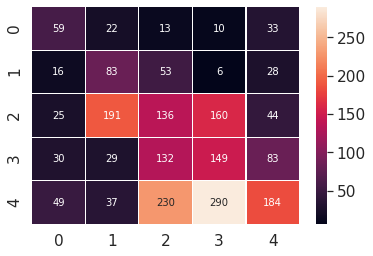

In [77]:
array = confusion_matrix(extended_original_predictions, extended_modified_predictions)
df_cm = pd.DataFrame(array, range(5), range(5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d", linewidths=.1) # font size

plt.show()